In [1]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import false_discovery_control
import importlib
from utils import rdm_regression, load_params, stepwise_rdm

In [2]:
lottery_objs = load_params.load_lotteries()
set_dicts = load_params.load_set_dicts()
behavior_results = load_params.load_behavior_results()
set_objs = load_params.load_sets(behavior_results)

In [3]:
first_subjects, replication_subjects = load_params.load_samples(roi_type='roi')

In [4]:
rois = ['vmPFC', 'PCC', 'M1', 'ACC', 'vSTR', 'V1', 'EC', 'MT']
stepwise_model, stepwise_rois, model_pvals = stepwise_rdm.first_stepwise(rois, first_subjects, set_objs=set_objs, verbose=True)
print(f'Selected ROIs: {stepwise_rois}')
print(stepwise_model.adj_r2, stepwise_model.pval)

first step of stepwise regression
Best first ROI: EC
Continue with: ['vmPFC', 'PCC', 'M1', 'ACC', 'vSTR', 'V1', 'MT']
-----
Step 2
Current model uses: ['EC']
Testing: ['vmPFC', 'PCC', 'M1', 'ACC', 'vSTR', 'V1', 'MT']
Best ROI: PCC, # significant p-values is 2.0, average -log(p-value): 1.2250840463873176
Refitting model with PCC
Surviving ROIs after addition of PCC: ['EC' 'PCC']
-----
Step 3
Current model uses: ['EC' 'PCC']
Testing: ['vmPFC', 'M1', 'ACC', 'vSTR', 'V1', 'MT']
Best ROI: M1, # significant p-values is 1.0, average -log(p-value): 1.1217278480505237
Refitting model with M1
Surviving ROIs after addition of M1: ['EC' 'M1' 'PCC']
-----
Step 4
Current model uses: ['EC' 'M1' 'PCC']
Testing: ['vmPFC', 'ACC', 'vSTR', 'V1', 'MT']
Best ROI: MT, # significant p-values is 1.0, average -log(p-value): 0.530140975032913
Refitting model with MT
Surviving ROIs after addition of MT: ['EC' 'M1' 'MT' 'PCC']
-----
Step 5
Current model uses: ['EC' 'M1' 'MT' 'PCC']
Testing: ['vmPFC', 'ACC', 'vSTR'

In [5]:
pd.DataFrame({'p': model_pvals, 'p_fdr': false_discovery_control(model_pvals)})

,p,p_fdr
0,0.346355,0.358299
1,0.612540,0.612540
2,0.023328,0.027994
3,0.197986,0.212128
4,0.150923,0.167693
5,0.004749,0.008381
6,0.002756,0.005513
7,0.081424,0.093951
8,0.005860,0.009253
9,0.001124,0.003371


In [6]:
first_reg_full = rdm_regression.RDMRegression(subjects=first_subjects, rois=stepwise_rois, sets=set_objs)
first_reg_neural = rdm_regression.RDMRegression(subjects=first_subjects, rois=stepwise_rois, sets=set_objs)
replication_reg_full = rdm_regression.RDMRegression(subjects=replication_subjects, rois=stepwise_rois, sets=set_objs)
replication_reg_neural = rdm_regression.RDMRegression(subjects=replication_subjects, rois=stepwise_rois, sets=set_objs)
reg_2d = rdm_regression.RDMRegression(subjects=replication_subjects, rois=[], sets=set_objs)

In [7]:
reg_2d.fit(use_explicit=True)
lm_2d = reg_2d.lm

first_reg_neural.fit(use_explicit=False)
first_lm_neural = first_reg_neural.lm
replication_reg_neural.fit(use_explicit=False)
replication_lm_neural = replication_reg_neural.lm

first_reg_full.fit(use_explicit=True)
first_lm_full = first_reg_full.lm
replication_reg_full.fit(use_explicit=True)
replication_lm_full = replication_reg_full.lm

In [8]:
replication_reg_neural.lm.rsquared_adj

0.5411395139333757

In [9]:
lm_2d.rsquared_adj, first_lm_full.rsquared_adj, replication_lm_full.rsquared_adj

(0.5482161463259586, 0.7558654175061853, 0.7821821654468099)

### plot fits

In [10]:
first_fits = first_reg_neural.lm.fittedvalues
replication_fits = replication_reg_neural.lm.fittedvalues
decoy_effects = np.array([set_obj.decoy_effect for set_obj in set_objs])

In [11]:
all_fits = pd.DataFrame({'actual_decoy_effect': decoy_effects, 
                         'first_fits': first_fits,
                         'replication_fits': replication_fits})
all_fits = all_fits.sort_values('actual_decoy_effect')

In [12]:
cvals = [-1, 0, 1]
decoy_colors = ['#3e8a83', '#ffffff', '#C42934']
colors_norm = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(colors_norm, cvals), decoy_colors))
DECOY_CMAP = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
fig, ax = plt.subplots(figsize=(41, 25), dpi=300)

n = len(decoy_effects)
    
cmap = DECOY_CMAP
negative_effects = all_fits.actual_decoy_effect[all_fits.actual_decoy_effect < 0]
positive_effects = all_fits.actual_decoy_effect[all_fits.actual_decoy_effect >= 0]
# scale negative effects from 0 to 0.35, positive effects from 0.65 to 1, for colormap
negative_effects_scaled = 0.35 * (negative_effects - negative_effects.min()) / (negative_effects.max() - negative_effects.min())
positive_effects_scaled = 0.35 * (positive_effects - positive_effects.min()) / (positive_effects.max() - positive_effects.min()) + 0.65
effects_scaled = np.concatenate([negative_effects_scaled, positive_effects_scaled])

bar_plot = ax.bar(np.arange(n), all_fits.actual_decoy_effect*100, color=cmap(effects_scaled), label='Observed')
# bar_plot2 = ax.bar(np.arange(n), all_fits.first_fits*100, color='none', edgecolor='black', alpha=1, linewidth=7, label='RDM regression (first)')
bar_plot2 = ax.bar(np.arange(n), all_fits.replication_fits*100, color='none', edgecolor='black', alpha=1, linewidth=7, label='RDM regression (replication)')
max_std = 5
ax.set_axisbelow(True)
plt.xlabel('Lottery set', fontsize=100)
plt.ylabel('Decoy effect (%)', fontsize=100)
x_tick_locs, x_ticks = plt.xticks()
plt.xticks(np.arange(0, n, 5), np.arange(1, n+1, 5), fontsize=75)
y_tick_locs, y_ticks = plt.yticks()
y_tick_locs = np.array([-40., -30., -20., -10., 0.,  10., 20.,  30.])
y_ticks_with_pct = [f'{int(tick)}%' for tick in y_tick_locs]
plt.yticks(y_tick_locs, y_ticks_with_pct)
min_effect = np.min(decoy_effects * 100)
max_effect = np.max(decoy_effects * 100)

min_y = min_effect - max_std - 1
max_y = max_effect + max_std + 1
plt.ylim([-1*max_y, max_y])
min_y_tick = 5 * np.round(min_y / 5, 0)
max_y_tick = 5 * np.round(max_y / 5, 0)
plt.yticks(np.arange(min_y_tick, max_y_tick, 5), fontsize=75)
plt.tick_params(axis='both', which='major', pad=60)
plt.grid(visible=True, which='major', color='#191919', axis='y')
plt.legend(fontsize=75, loc='upper left')
_ = [spine.set_linewidth(4) for spine in ax.spines.values()]
plt.savefig('../../results/figs/fig2/fig2_replication_fit.png', bbox_inches='tight')

#### RDM explain variance beyond explicit attributes

In [13]:
fitting_rsquared = pd.read_csv('../../results/fitting_results.csv', index_col=0)

In [14]:
fitting_rsquared

,full_r2_adj,neural_r2_adj,attribute_r2_adj
first,0.755865,0.753198,0.548216
replication,0.782182,0.541140,0.548216


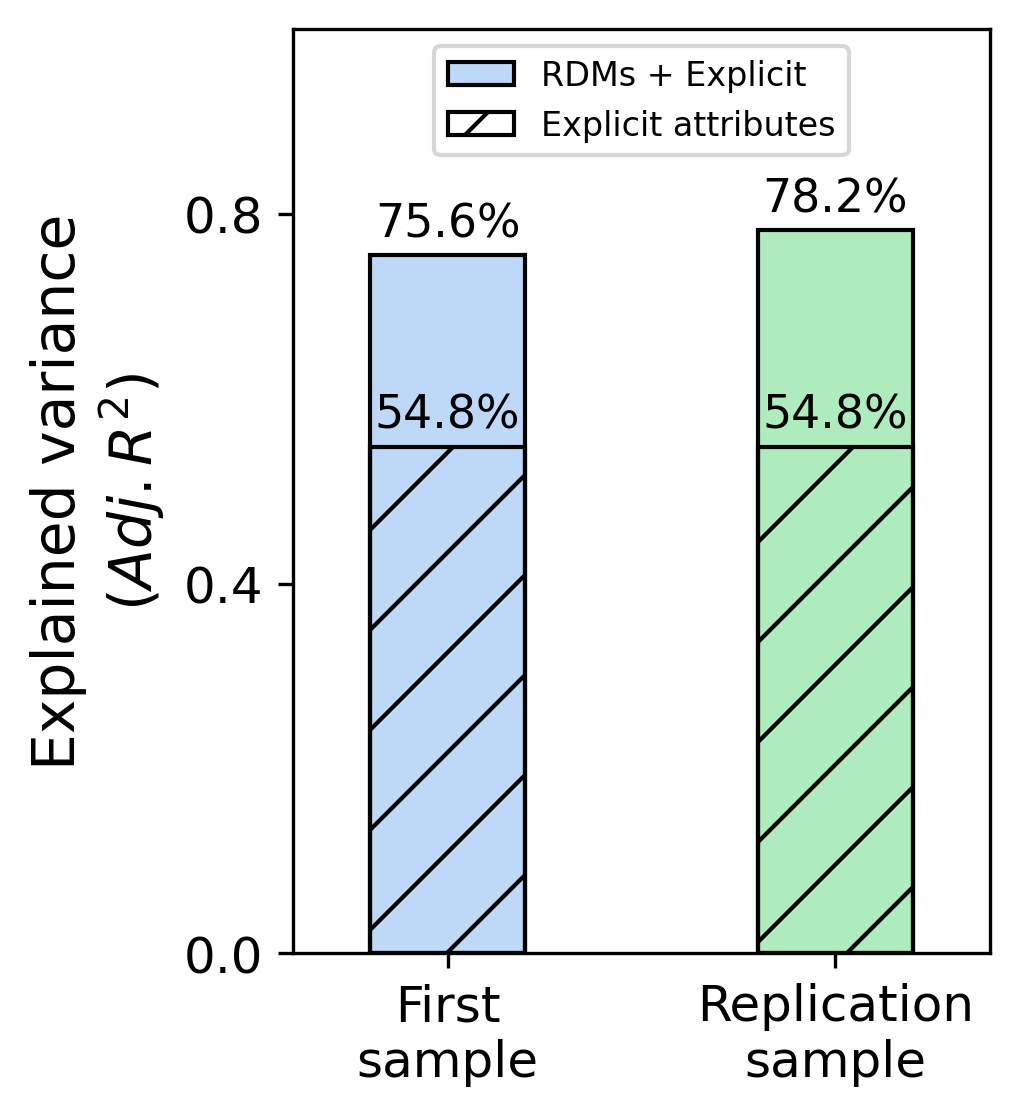

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3, 4), dpi=300, sharey=True)
ticksize = 12
labelsize = 14
textsize = 11
width = 0.1
positions = np.arange(0, 0.5, 0.25)
ax.bar(positions, fitting_rsquared.loc[:, 'full_r2_adj'], color=['#BDD9F7', '#AFECBD'], edgecolor='black', width=width, label='Full')
ax.bar(positions, fitting_rsquared.loc[:, 'attribute_r2_adj'], alpha=1, color='none', edgecolor='black', hatch='/', width=width, label='Explicit attributes')
ax.set_ylabel('Explained variance\n($Adj. R^{2}$)', fontsize=labelsize)
plt.ylim([0, 1])
plt.xlim([-0.1, 0.35])
plt.xticks(positions, ['First\nsample', 'Replication\nsample'], fontsize=ticksize)
yticks = ax.get_yticks()
ylabels = ax.get_yticklabels()
ax.set_yticks(yticks[::2])
ax.set_yticklabels(ylabels[::2], fontsize=ticksize)
ax.legend(['RDMs + Explicit', 'Explicit attributes'], fontsize=ticksize-4, loc='upper center')

plt.text(positions[0]-0.047, fitting_rsquared.loc['first', 'attribute_r2_adj']+0.02, f"{fitting_rsquared.loc['first', 'attribute_r2_adj']*100:.1f}%", fontsize=textsize)
plt.text(positions[1]-0.047, fitting_rsquared.loc['replication', 'attribute_r2_adj']+0.02, f"{fitting_rsquared.loc['replication', 'attribute_r2_adj']*100:.1f}%", fontsize=textsize)
plt.text(positions[0]-0.047, fitting_rsquared.loc['first', 'full_r2_adj']+0.02, f"{fitting_rsquared.loc['first', 'full_r2_adj']*100:.1f}%", fontsize=textsize)
plt.text(positions[1]-0.047, fitting_rsquared.loc['replication', 'full_r2_adj']+0.02, f"{fitting_rsquared.loc['replication', 'full_r2_adj']*100:.1f}%", fontsize=textsize)
plt.savefig('../../results/figs/fig2/fig2_nested_fitting.png', bbox_inches='tight')